# On-Balance Volume Strategy

In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
import pandas as pd
import time
from datetime import date
import json, re, sys, h5py
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import sys
import seaborn as sns
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')
from Loader_v2 import Loader
ldr = Loader(pwd='')

### 1) OBV Exponential Moving Average

* If OBV > OBV_EMA buy, else sell.

In [2]:
def OBV(pr, vol, ndays=20):
    OBV = []
    OBV.append(0)
    code = pr.columns[0]
    for i in range(1, len(pr[code])):
        if pr[code][i] > pr[code][i-1]:
            OBV.append(OBV[-1] + vol[code][i])
        elif pr[code][i] < pr[code][i-1]:
            OBV.append(OBV[-1] - vol[code][i])
        else :
            OBV.append(OBV[-1])
    pr.columns = ['close']
    vol.columns = ['volume']
    total = pd.concat([pr,vol],axis=1)
    assert len(pr) == len(vol) == len(OBV)
    total['OBV'] = OBV
    total['OBV_EMA'] = total['OBV'].ewm(com=ndays).mean()
    return total

In [3]:
def Signal(obv):
    sigPriceBuy = []
    sigPriceSell = []
    flag = -1 
    for i in range(0,len(obv)):
        if obv['OBV'][i] > obv['OBV_EMA'][i] and flag != 1:
            sigPriceBuy.append(obv['close'][i])
            sigPriceSell.append(np.nan)
            flag = 1
        elif obv['OBV'][i] < obv['OBV_EMA'][i] and flag != 0:    
            sigPriceSell.append(obv['close'][i])
            sigPriceBuy.append(np.nan)
            flag = 0
        else: 
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
    obv['BuySignalPrice'] = sigPriceBuy
    obv['SellSignalPrice'] = sigPriceSell
    return obv

In [4]:
def OBV_Run(start, end, code, ndays=20, doplot=True):
    pr = ldr.GetPricelv2(start, end, [code])
    vol = ldr.GetVolumelv2(start, end, [code])
    vol = vol.astype(str)
    vol[code] = vol[code].map(lambda x : x.replace(',',''))
    vol[code] = vol[code].astype(float)
    obv = OBV(pr,vol,ndays=ndays)
    if doplot :
        plt.style.use('fivethirtyeight')
        obv[['OBV','OBV_EMA']].plot(figsize=(8,6))
    obv_sig = Signal(obv)
    if doplot :
        plt.figure(figsize=(8,6))
        plt.scatter(obv_sig.index, obv_sig['BuySignalPrice'], color='green',label='BuySignal',marker='^',alpha=1)
        plt.scatter(obv_sig.index, obv_sig['SellSignalPrice'], color='red',label='SellSignal',marker='v',alpha=1)
        plt.plot(obv_sig['close'], label='Close Price', alpha=0.35)
        plt.xticks([],rotation=45)
        plt.title('OBV on {} during {} ~ {}'.format(code,start,end))
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        plt.show()
    _, rst = BackTest(obv_sig)
    rst.index = [code]
    return rst

In [5]:
def BackTest(obv):
    tmp = obv[(~obv['BuySignalPrice'].isnull())|(~obv['SellSignalPrice'].isnull())]
    tmp['BuySignalPrice'] = tmp['BuySignalPrice'].fillna(0)
    tmp['SellSignalPrice'] = tmp['SellSignalPrice'].fillna(0)
    tmp['series'] = tmp['BuySignalPrice'] + tmp['SellSignalPrice']
    tmp['return'] = tmp['series'].pct_change()+1
    tmp2 = tmp[tmp.SellSignalPrice!=0.0]
    cm_rt = tmp2['return'].cumprod()[-1]
    hit_ratio = round(len(tmp2[tmp2['return']>=1]) / len(tmp2),2)
    best_rt = tmp2['return'].max()-1
    worst_rt = tmp2['return'].min()-1
    ar_mean = tmp2['return'].mean()
    gr_mean = np.exp(np.log(cm_rt)/len(tmp2))
    mdd = MDD(obv[['close']])
    SR = SharpeRatio(tmp2[['return']]-1)
    test_rst = pd.DataFrame(columns=['CumulativeReturn','HitRatio','BestReturn','WorstReturn','MDD','SimpleMean','GeoMean','#Trade'])
    test_rst.loc[0,'CumulativeReturn'] = round(cm_rt,2)
    test_rst.loc[0,'HitRatio'] = hit_ratio
    test_rst.loc[0,'BestReturn'] = round(best_rt,2)
    test_rst.loc[0,'WorstReturn'] = round(worst_rt,2)
    test_rst.loc[0,'SimpleMean'] = round(ar_mean,2)
    test_rst.loc[0,'GeoMean'] = round(gr_mean,2)
    test_rst.loc[0,'MDD'] = round(mdd*(-1),2)
    test_rst.loc[0,'SharpeRatio'] = round(SR,2)
    test_rst.loc[0,'#Trade'] = round(len(tmp2),2)
    return tmp2, test_rst

In [6]:
def MDD(pr):
    code = pr.columns[0]
    x = pr[code]
    """
    MDD(Maximum Draw-Down)
    :return: (peak_upper, peak_lower, mdd rate)
    """
    arr_v = np.array(x)
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    return round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper],2)

In [7]:
def SharpeRatio(rt_df, bncmrk=0.02):
    SR = np.sqrt(len(rt_df))*(rt_df['return'].mean() - bncmrk) / rt_df['return'].std()
    return SR

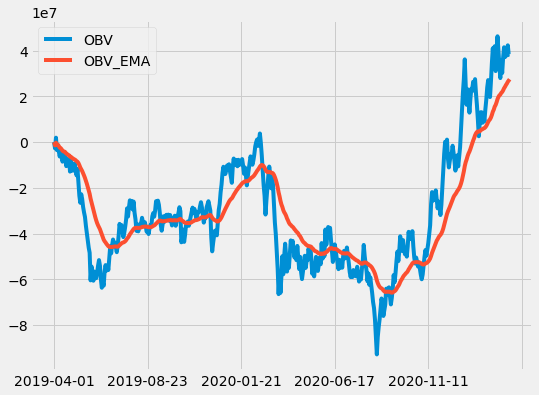

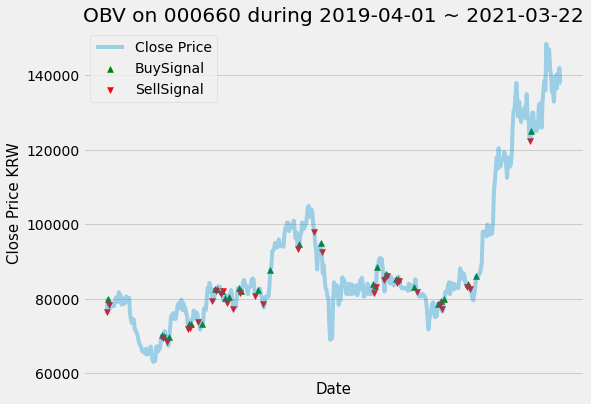

Wall time: 3.5 s


,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
000660,1.22,0.23,0.42,-0.04,0.34,1.01,1.01,31,-0.71


In [168]:
%%time
OBV_Run('2019-04-01','2021-03-22','000660')

In [169]:
mcp = ldr.GetMarcaplv2('2021-03-22','2021-03-22')

In [184]:
mcpTop200 = mcp.T.sort_values(by=['2021-03-22'],ascending=False).index[:50].to_list()

In [185]:
%%time
start = '2020-04-01'
end = '2021-03-22'
total = pd.DataFrame()
for cd in mcpTop200:
    try :
        total = pd.concat([total,OBV_Run(start,end,cd,doplot=False)])
    except :
        print(cd)

326030
352820
Wall time: 2min 21s


In [212]:
total.sort_values(by=['SharpeRatio'],ascending=False).head(5)

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
034730,2.23,0.57,0.62,-0.02,0.43,1.14,1.12,7,1.37
006400,2.63,0.33,0.71,-0.03,0.21,1.21,1.17,6,1.32
011780,1.64,0.5,0.3,-0.02,0.26,1.07,1.06,8,1.04
003670,1.77,0.75,0.64,-0,0.18,1.18,1.15,4,1.04
011200,4.18,0.4,2.82,-0.02,0.18,1.58,1.33,5,1.01


In [215]:
%%time
start = '2020-04-01'
end = '2021-03-22'
PTset = pd.DataFrame()
for cd in ['005930','005935','034220','066570']:
    try :
        PTset = pd.concat([PTset,OBV_Run(start,end,cd,doplot=False)])
    except :
        print(cd)

Wall time: 12.5 s


In [216]:
PTset

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.43,0.44,0.27,-0.03,0.11,1.02,1.02,16,0.27
005935,1.62,0.5,0.38,-0.02,0.11,1.07,1.06,8,0.99
034220,1.06,0.2,0.2,-0.04,0.13,1.01,1.01,10,-0.54
066570,1.5,0.2,0.6,-0.03,0.23,1.05,1.04,10,0.55


In [217]:
%%time
start = '2020-04-01'
end = '2021-03-22'
PTset2 = pd.DataFrame()
for cd in ['005930','005935','034220','066570']:
    try :
        PTset2 = pd.concat([PTset2,OBV_Run(start,end,cd,ndays=10,doplot=False)])
    except :
        print(cd)

Wall time: 12.5 s


In [218]:
PTset2

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.39,0.56,0.13,-0.03,0.11,1.02,1.02,18,-0.05
005935,1.66,0.5,0.4,-0.02,0.11,1.04,1.04,14,0.73
034220,1.56,0.33,0.44,-0.03,0.13,1.04,1.04,12,0.63
066570,2.08,0.44,0.33,-0.03,0.23,1.05,1.05,16,1.10


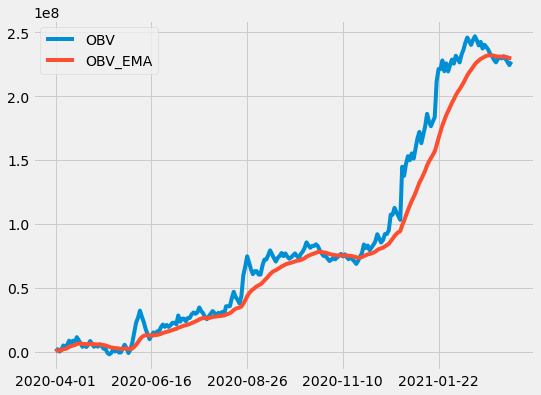

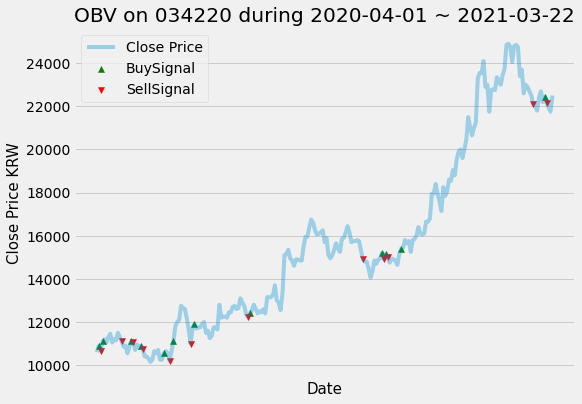

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
034220,1.56,0.33,0.44,-0.03,0.13,1.04,1.04,12,0.63


In [225]:
OBV_Run(start,end,'034220',ndays=10,doplot=True)

In [8]:
ldr.FindCodeByName('HMM')

'011200'

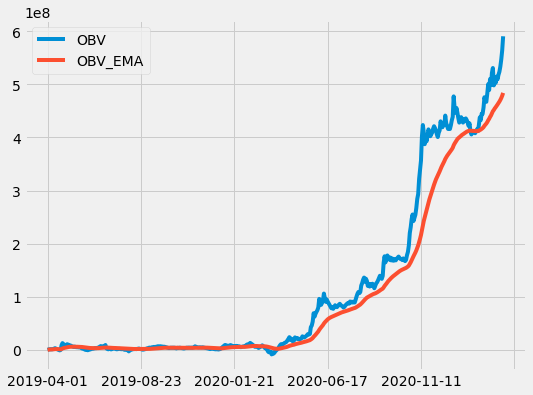

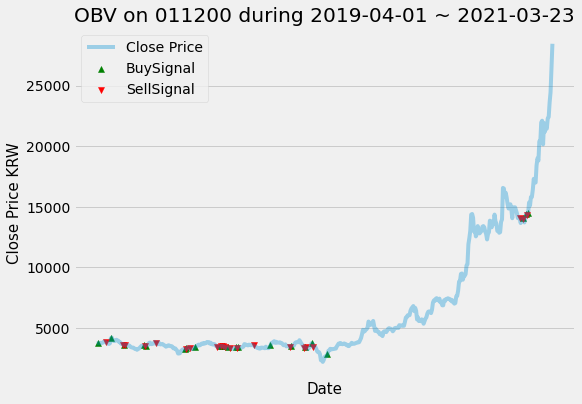

Wall time: 4.59 s


,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
011200,3.93,0.29,4.01,-0.13,0.18,1.18,1.07,21,0.84


In [10]:
%%time
OBV_Run('2019-04-01','2021-03-23','011200')

---

### 2) VR (Volume Ratio)

* VR = (volume when price up + volume when no change * 0.5) / (volume when price down + volume when no change * 0.5) * 100
* If VR<70 Buy, else VR>450 Sell.

In [280]:
q1 = ldr.GetPricelv2('2019-04-01','2021-03-22',['005930'])
q11 = ldr.GetVolumelv2('2019-04-01','2021-03-22',['005930'])

In [281]:
q11['005930'] = q11['005930'].astype(str)
q11['005930'] = q11['005930'].map(lambda x : x.replace(',',''))
q11['005930'] = q11['005930'].astype(float)

In [282]:
def VR(pr_df,vol_df):
    pr = pr_df.copy()
    vol = vol_df.copy()
    Up = []
    Down = []
    Stay = []
    code = pr.columns[0]
    diff_pr = pr.diff(1)
    for i in range(0, len(pr)):
        if i == 0 :
            Up.append(0)
            Down.append(0)
            Stay.append(0)
        else :
            if diff_pr[code][i] > 0 :
                Up.append(vol[code][i])
                Down.append(0)
                Stay.append(0)
            elif diff_pr[code][i] < 0 :
                Down.append(vol[code][i])
                Up.append(0)
                Stay.append(0)
            else :
                Stay.append(vol[code][i])
                Up.append(0)
                Down.append(0)
    pr.columns = ['close']
    vol.columns = ['volume']
    rst = pd.concat([pr,vol],axis=1)
    rst['Up'] = Up
    rst['Down'] = Down
    rst['Stay'] = Stay
    rst['nomi'] = rst['Up'] + rst['Stay']*0.5
    rst['denomi'] = rst['Down'] + rst['Stay']*0.5
    rst['VR'] = (rst['nomi'].rolling(20).sum() / rst['denomi'].rolling(20).sum()) * 100
    
    return rst

In [283]:
qq = VR(q1,q11)

In [284]:
def VR_Signal(vr_df):
    vr = vr_df.copy()
    sigPriceBuy = []
    sigPriceSell = []
    flag = -1 
    for i in range(0,len(vr)):
        if vr['VR'][i] < 70 and flag != 1:
            sigPriceBuy.append(vr['close'][i])
            sigPriceSell.append(np.nan)
            flag = 1
        elif vr['VR'][i] > 250 and flag != 0:    
            sigPriceSell.append(vr['close'][i])
            sigPriceBuy.append(np.nan)
            flag = 0
        else: 
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
    vr['BuySignalPrice'] = sigPriceBuy
    vr['SellSignalPrice'] = sigPriceSell
    return vr

In [285]:
qq_vr = VR_Signal(qq)

In [286]:
qq_vr['VR'].describe()

count    469.000000
mean     127.871158
std       53.507138
min       32.502460
25%       90.241490
50%      119.105045
75%      164.460565
max      302.073294
Name: VR, dtype: float64

* As you can see from above desriptive statistics, VR>450 doesn't exist...
* Seems like not proper indicator for volume strategy.

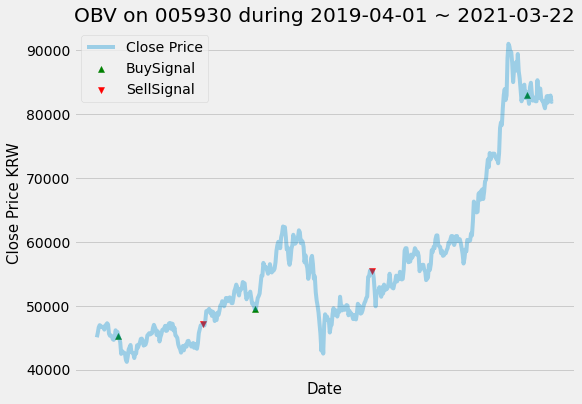

In [287]:
code = '005930'
start = '2019-04-01'
end = '2021-03-22'
plt.figure(figsize=(8,6))
plt.scatter(qq_vr.index, qq_vr['BuySignalPrice'], color='green',label='BuySignal',marker='^',alpha=1)
plt.scatter(qq_vr.index, qq_vr['SellSignalPrice'], color='red',label='SellSignal',marker='v',alpha=1)
plt.plot(qq_vr['close'], label='Close Price', alpha=0.35)
plt.xticks([],rotation=45)
plt.title('OBV on {} during {} ~ {}'.format(code,start,end))
plt.xlabel('Date',fontsize=15)
plt.ylabel('Close Price KRW',fontsize=15)
plt.legend(loc='upper left')
plt.show()